# Exercise II: k-Nearest Neighbors (k-NN)

[k-NN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) is a simple and useful non-parametric method that is commonly used for both classification and regression. It relies on having some method of calculating distance between data points, and using the the "nearest" observations to predict the target value for new ones.

<figure>
    <center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/1024px-KnnClassification.svg.png" alt="KNN Illustration" width="400"/></center>
    <figcaption>
        <i>
            Example of k-NN classification. The test sample (green dot) should be classified either to blue squares or to red triangles. If k = 3 (solid line circle) it is assigned to the red triangles because there are 2 triangles and only 1 square inside the inner circle. If k = 5 (dashed line circle) it is assigned to the blue squares (3 squares vs. 2 triangles inside the outer circle).
            <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">
                Wikipedia
            </a>
        </i>
    </figcaption>
</figure>

```{admonition} The Curse of Dimensionality
    :class: note
> *The curse of dimensionality refers to various phenomena that arise when analyzing and organizing data in high-dimensional spaces that do not occur in low-dimensional settings such as the three-dimensional physical space of everyday experience. [Wikipedia](https://en.wikipedia.org/wiki/Curse_of_dimensionality)*

**k-NN normally performs better with a limited number of features**. In simplified terms, distances become increasingly large in higher dimensionality spaces.
```

## Loading the Dataset

In this exercise we will use the [Iris Flower Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). This dataset is commonly used for demonstrating simple statistical concepts and therefore `scikit-learn` provides us with a utility function to load it.

In [18]:
import pandas as pd

from sklearn.datasets import load_iris

TARGET_NAME = "class"

# Read a type of dictionary with the dataset as well as some metadata.
iris_dataset = load_iris()

# Read the features and targets.
X = pd.DataFrame(iris_dataset.data, columns=iris_dataset.feature_names)
y = pd.Series(iris_dataset.target, name=TARGET_NAME)

## Basic Exploration

In [19]:
print(iris_dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

<figure>
    <center><img src="https://miro.medium.com/max/362/1*XN85Vu-SmkJc3TkwgTx5Kw.jpeg" alt="Sepal and petal lengths" width="400"/></center>
    
</figure>

In [71]:
import numpy as np

# Class colors
COLORS = "rgba(255, 0, 0, 0.3)", "rgba(0, 255, 0, 0.3)", "rgba(0, 0, 255, 0.3)"

# Create a unified dataframe.
data = pd.concat([X, y], axis="columns")


# Set class background color
def set_class_color(class_index: str) -> str:
    return f"background-color: {COLORS[class_index]};"


def set_class_name(class_index: str) -> str:
    return iris_dataset.target_names[class_index]


# Select some sample indices
sample_indices = np.linspace(0, len(data) - 5, 3, dtype=int)
sample_indices = [index for i in sample_indices for index in range(i, i + 5)]

# Display table
data.iloc[sample_indices, :].style.background_gradient().map(lambda x: set_class_color(x), subset=[TARGET_NAME]).format(
    {TARGET_NAME: set_class_name}).set_properties(**{
        "border": "1px solid black"
    }, subset=[TARGET_NAME]).set_properties(**{
        "text-align": "center"
    }).set_table_styles([
        dict(selector="th", props=[("font-size", "14px")]),
        dict(selector="td", props=[("font-size", "12px")]),
    ]).format("{:.2f}", subset=[col for col in data.columns if col != TARGET_NAME])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.10,3.50,1.40,0.20,setosa
1,4.90,3.00,1.40,0.20,setosa
2,4.70,3.20,1.30,0.20,setosa
3,4.60,3.10,1.50,0.20,setosa
4,5.00,3.60,1.40,0.20,setosa
72,6.30,2.50,4.90,1.50,versicolor
73,6.10,2.80,4.70,1.20,versicolor
74,6.40,2.90,4.30,1.30,versicolor
75,6.60,3.00,4.40,1.40,versicolor
76,6.80,2.80,4.80,1.40,versicolor


In [52]:
data.iloc[sample_indices, :].style.background_gradient().applymap(
    set_class_color,
    subset=[TARGET_NAME]).format(set_class_name, subset=[
        TARGET_NAME
    ]).set_properties(**{
        "border": "1px solid black"
    }, subset=[TARGET_NAME]).set_properties(**{
        "text-align": "center"
    }).set_table_styles([
        dict(selector="th", props=[("font-size", "14px")]),
        dict(selector="td", props=[("font-size", "12px")]),
    ])

/tmp/ipykernel_288488/3579376705.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  data.iloc[sample_indices, :].style.background_gradient().applymap(


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.100000,3.500000,1.400000,0.200000,setosa
1,4.900000,3.000000,1.400000,0.200000,setosa
2,4.700000,3.200000,1.300000,0.200000,setosa
3,4.600000,3.100000,1.500000,0.200000,setosa
4,5.000000,3.600000,1.400000,0.200000,setosa
72,6.300000,2.500000,4.900000,1.500000,versicolor
73,6.100000,2.800000,4.700000,1.200000,versicolor
74,6.400000,2.900000,4.300000,1.300000,versicolor
75,6.600000,3.000000,4.400000,1.400000,versicolor
76,6.800000,2.800000,4.800000,1.400000,versicolor


In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [22]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.00,150.00,150.00,150.00
mean,5.84,3.06,3.76,1.20
std,0.83,0.44,1.77,0.76
min,4.30,2.00,1.00,0.10
25%,5.10,2.80,1.60,0.30
50%,5.80,3.00,4.35,1.30
75%,6.40,3.30,5.10,1.80
max,7.90,4.40,6.90,2.50


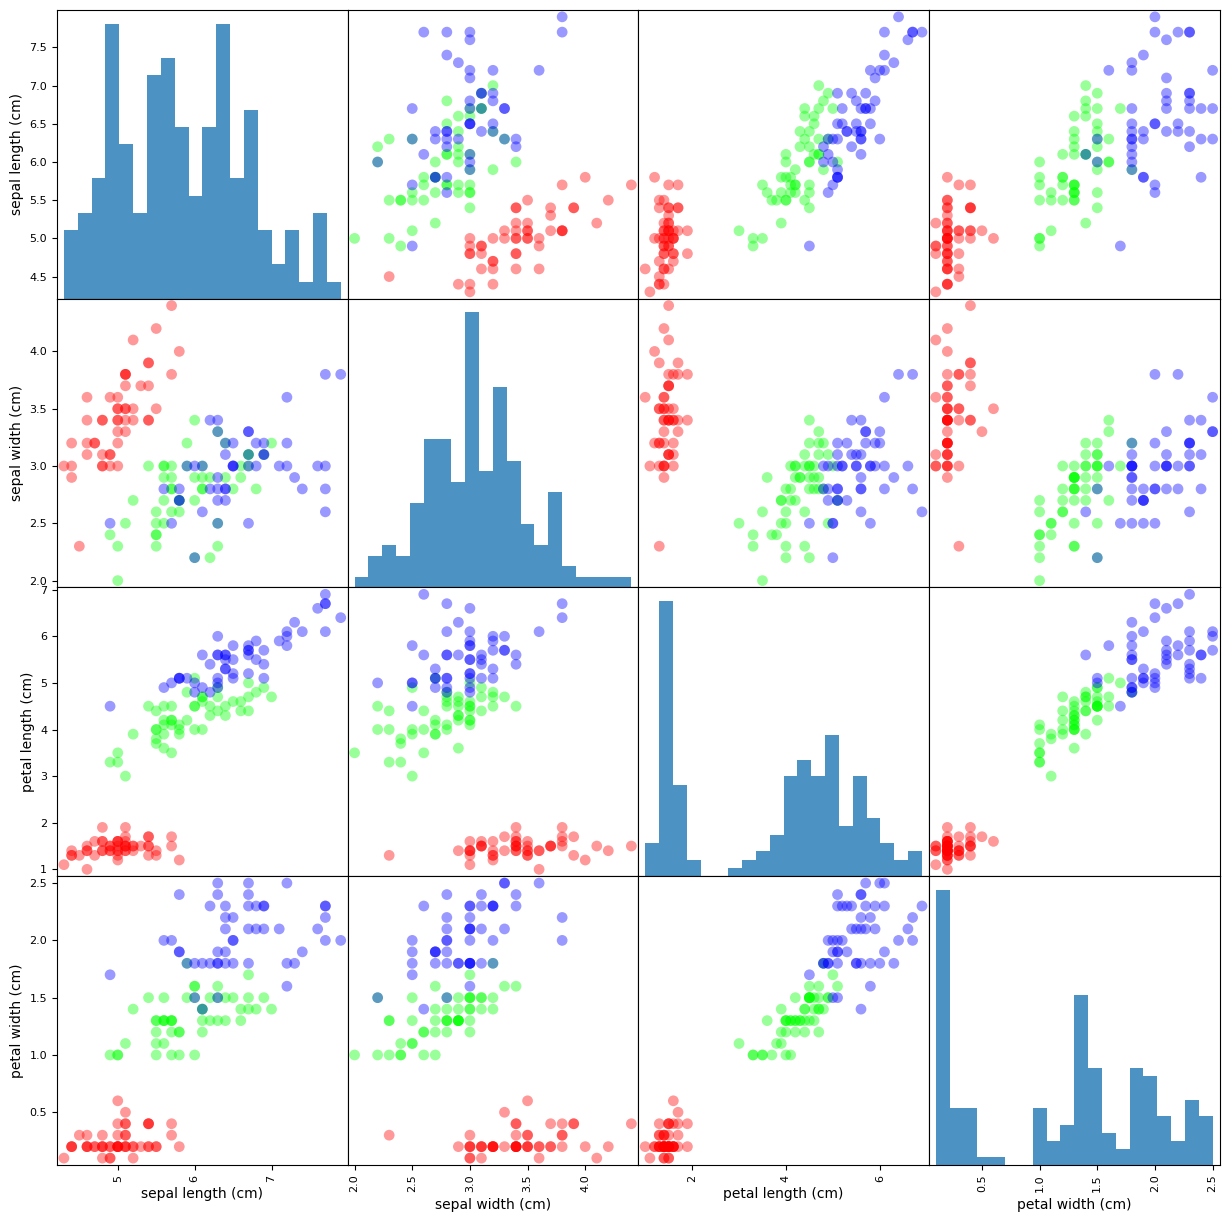

In [23]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap([(1, 0, 0), (0, 1, 0), (0, 0, 1)])
_ = pd.plotting.scatter_matrix(X,
                               c=y,
                               cmap=cmap,
                               figsize=(15, 15),
                               marker='o',
                               hist_kwds={
                                   'bins': 20,
                                   'alpha': 0.8
                               },
                               s=60,
                               alpha=0.4)

## Train/Test Split

```{admonition} [Train-Test Split](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/)
    :class: note
*A lot can be said regarding the different approaches for model validation and evaluation (which we'll discuss later in the course), but the general guideline is that, since our model should detect underlying trends in the data, we would evaluate its performance over unseen data. Therefore, we'll split our data into a training (for model fitting) and testing (for evaluation).*
```

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0,
                                                    test_size=0.25)

In [25]:
from myst_nb import glue

glue("n_train", len(X_train), display=False)
glue("n_test", len(X_test), display=False)

We now have a training dataset consisting of {glue:}`n_train` observations and a test dataset with {glue:}`n_test` observations.

## Model Creation

```{admonition} [Models and Estimators](https://scikit-learn.org/stable/getting_started.html)
    :class: note
> *Machine Learning algorithms and models are easily accesible through numberous packages, namely [scikit-learn] (https://scikit-learn.org/stable/index.html). While different estimators provide different advantages and pitfalls, they share some basic properties, making it easy for users to use them.
*

*Since these estimators are basically just algorithms and formulas that need to be tailored to the dataset being used, all estimators have a 'fit' method, (unsurprisingly) fitting the estimators to generalize to any specific data.*
```

In [26]:
from sklearn.neighbors import KNeighborsClassifier

k = 1

knn = KNeighborsClassifier(n_neighbors=k)
_ = knn.fit(X_train, y_train)

## Model Evaluation

### Misclassification Rate / Accuracy

<figure>
    <center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f0453f2614cd29f5dd49c2c9a0ef807985128e9e" alt="Accuracy" width="400"/></center>
    <figcaption>
        <i>
            Accuracy is defined as 1-error rate. It is used as a statistical measure of how well a classification test performes.
            <a href="https://en.wikipedia.org/wiki/Accuracy_and_precision">
                Wikipedia
            </a>
        </i>
    </figcaption>
</figure>

In [27]:
import numpy as np

y_predicted = knn.predict(X_test)

misclassification_rate = np.mean(y_predicted != y_test) * 100

In [28]:
glue("misclassification_rate", f"{misclassification_rate:.3f}", display=False)
glue("n_correct", (y_predicted == y_test).sum(), display=False)

Our model achieved a misclassification_rate of {glue:}`misclassification_rate`%, meaning it correctly predicted {glue:}`n_correct` of {glue:}`n_test` target values in our test set.

Another way to look at it is:

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_score(y_test, y_predicted) * 100

97.36842105263158

### Confusion Matrix

<figure>
    <center><img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*qcK0IMq6gxIsoKzaTmSYiw.jpeg" alt="Confusion Matrix" width="400"/></center>
    <figcaption>
        <i>
            A confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known.
            <a href="https://shivang-ahd.medium.com/all-about-confusion-matrix-preparing-for-interview-questions-fddea115a7ee">
                Medium
            </a>
        </i>
    </figcaption>
</figure>

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
confusion_matrix(y_test, y_predicted)

array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  0,  9]])

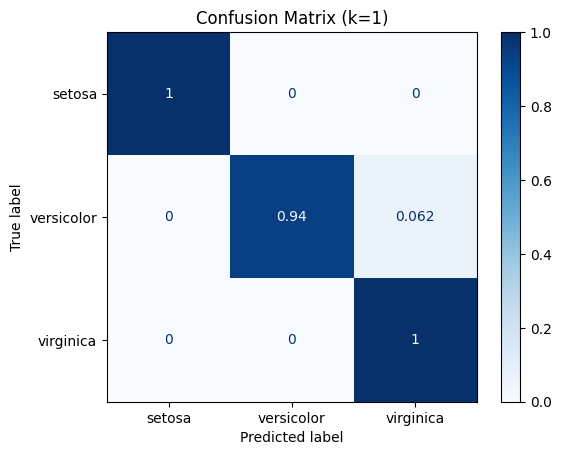

In [35]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay.from_estimator(knn,
                             X_test,
                             y_test,
                             display_labels=iris_dataset.target_names,
                             cmap=plt.cm.Blues,
                             normalize="true")
_ = disp.ax_.set_title(f"Confusion Matrix (k={k})")